In [1]:
import string
import numpy as np
import pandas as pd 
from numpy import array
from pickle import load
from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re
import tensorflow as tf
from tqdm import tqdm
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array

In [2]:
image_path = "../../Flicker8k_Dataset"
dir_Flickr_text = "../../Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16183


In [3]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)
data.head(100)

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
...,...,...,...
95,0,102351840_323e3de834.jpg,a man drilling a hole in the ice .
96,1,102351840_323e3de834.jpg,a man is drilling through the frozen ice of a ...
97,2,102351840_323e3de834.jpg,a person in the snow drilling a hole in the ice .
98,3,102351840_323e3de834.jpg,a person standing on a frozen lake .


In [4]:
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [5]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [6]:
vocabulary

['a',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 '.',
 'a',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 '.',
 'a',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 '.',
 'a',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 '.',
 'a',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 '.',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'tri-colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 '.',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 '.',
 'two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 '.',
 'two'

In [7]:
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [8]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 40455
len(caption) : 40455


In [9]:
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [10]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [11]:
clean_vocabulary = []
for txt in data.caption.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


In [12]:
clean_vocabulary

['child',
 'in',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 'girl',
 'going',
 'into',
 'wooden',
 'building',
 'little',
 'girl',
 'climbing',
 'into',
 'wooden',
 'playhouse',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 'little',
 'girl',
 'in',
 'pink',
 'dress',
 'going',
 'into',
 'wooden',
 'cabin',
 'black',
 'dog',
 'and',
 'spotted',
 'dog',
 'are',
 'fighting',
 'black',
 'dog',
 'and',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 'black',
 'dog',
 'and',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 'two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 'two',
 'dogs',
 'on',
 'pavement',
 'moving',
 'toward',
 'each',
 'other',
 'little',
 'girl',
 'covered',
 'in',
 'paint',
 'sits',
 'in',
 'front',
 'of',
 'painted',


In [13]:
PATH = "../../Flicker8k_Dataset/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [14]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot
    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['../../Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '../../Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '../../Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '../../Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '../../Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '../../Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '../../Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '../../Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '../../Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '../../Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [15]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [16]:
def data_limiter(num, total_captions, all_img_name_vector):
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

In [17]:
train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [18]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 40000
len(all_captions) : 40000


In [19]:
from keras.applications.vgg16 import VGG16, preprocess_input
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

In [20]:
image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [21]:
image_model.layers[0].output

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [22]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [23]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
imageData = load_image('../../Flicker8k_Dataset/1001773457_577c3a7d70.jpg')
# print(imageData[0].shape)
im = Image.open('../../Flicker8k_Dataset/1001773457_577c3a7d70.jpg')
width, height = im.size
print(width, height)
temp_image = np.array(im)
fig = plt.figure(figsize=(15, 7))
fig.add_subplot(1, 2, 1)

plt.imshow(temp_image)
fig.add_subplot(rows, columns, 2)
plt.imshow(imageData[0], interpolation='nearest')
plt.show()

500 375


NameError: name 'rows' is not defined

In [25]:
image_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [26]:
%%time
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|█████████████████████████████████████████| 127/127 [08:29<00:00,  4.01s/it]

CPU times: user 1h 11min 20s, sys: 3min 46s, total: 1h 15min 6s
Wall time: 8min 29s


1/1 [==============================] - 0s 106ms/step


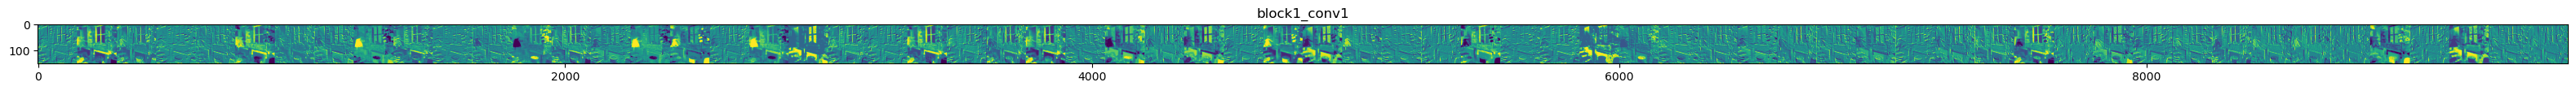

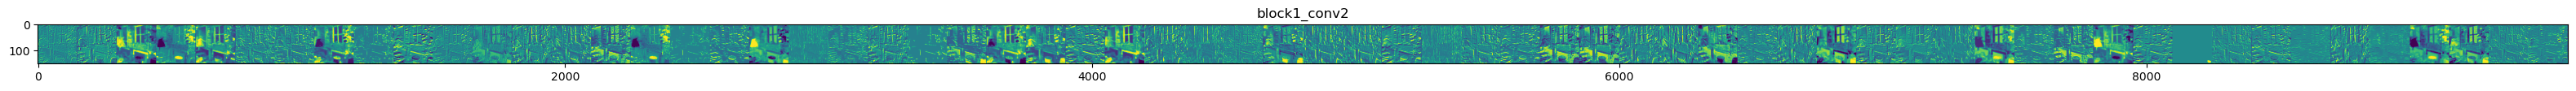

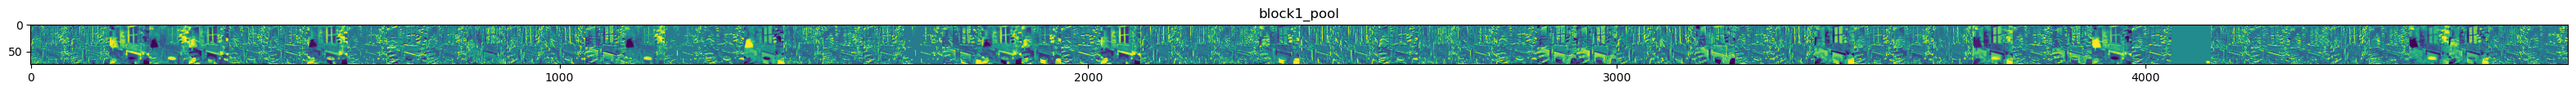

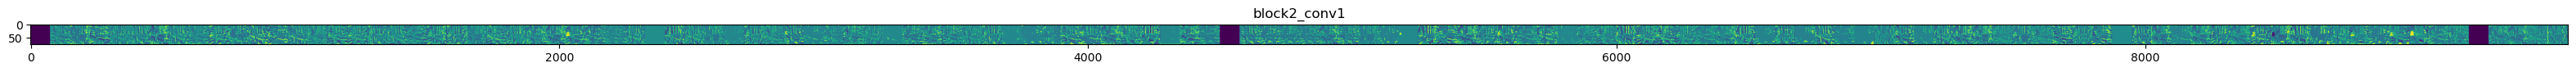

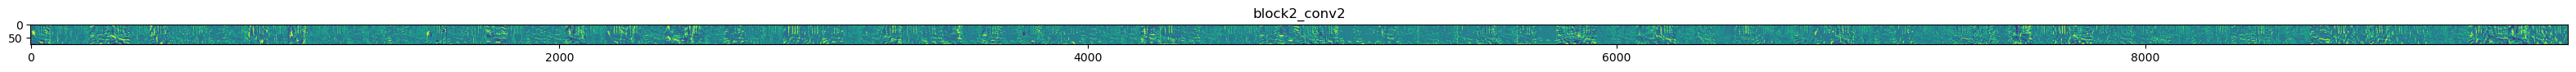

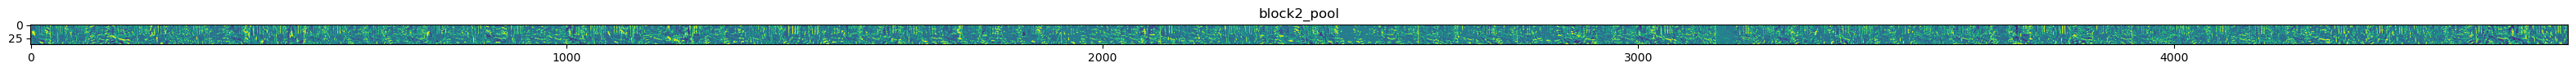

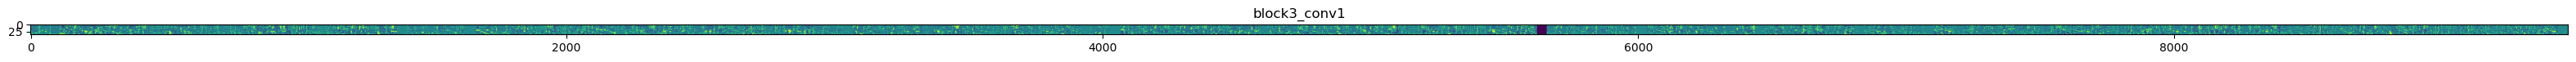

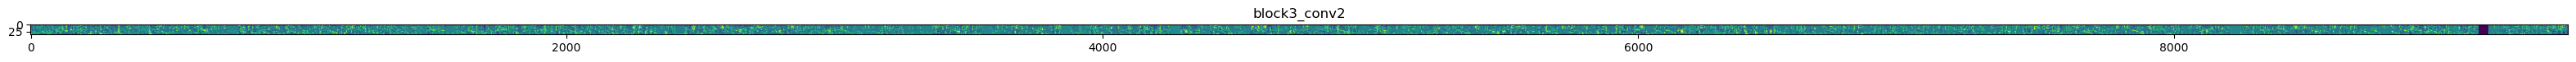

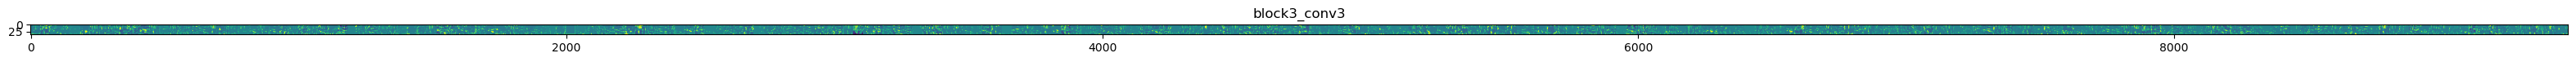

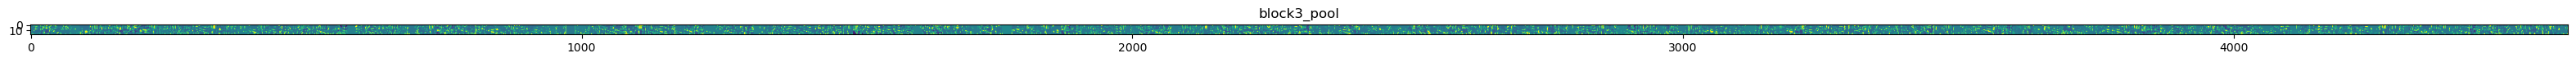

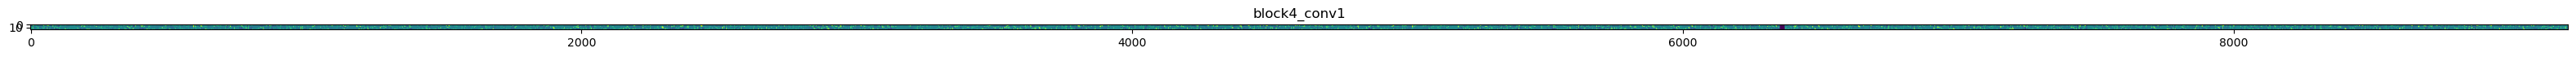

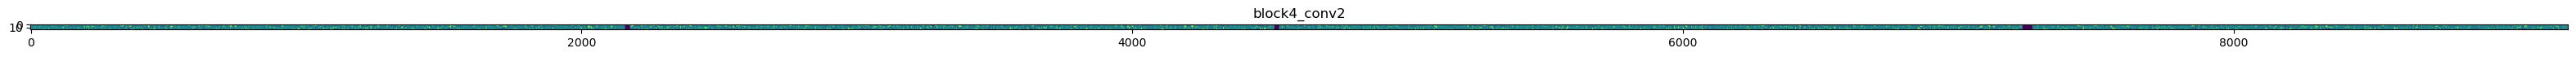

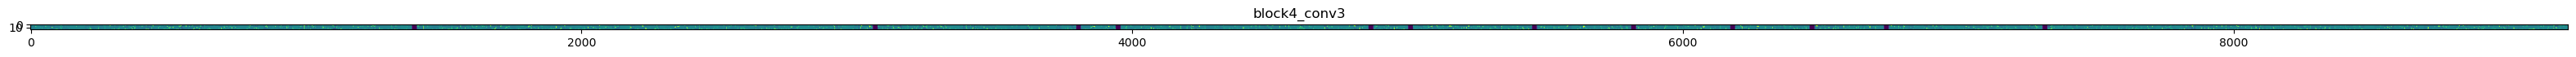

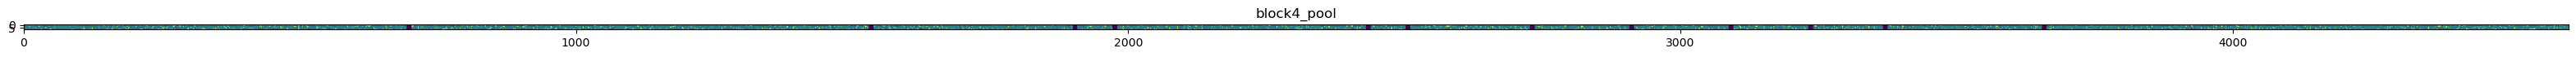

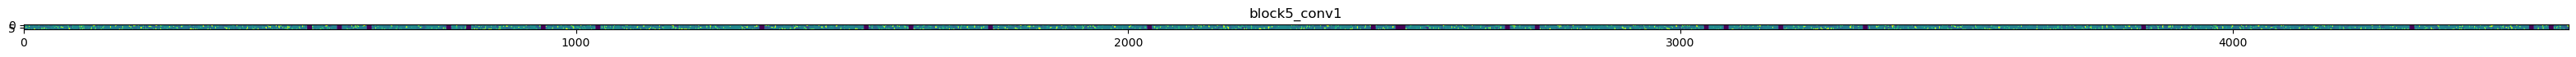

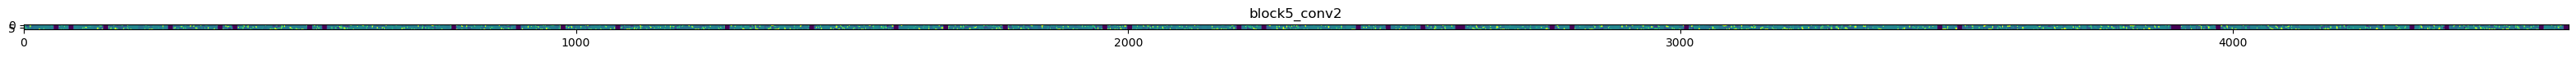

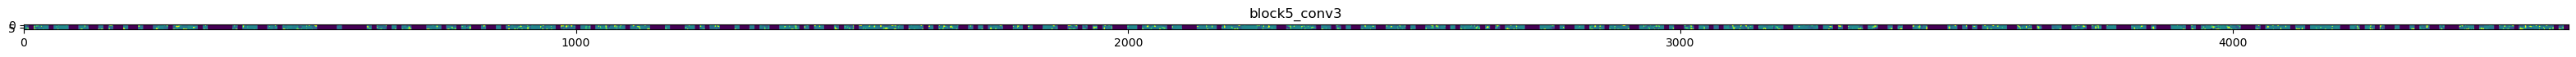

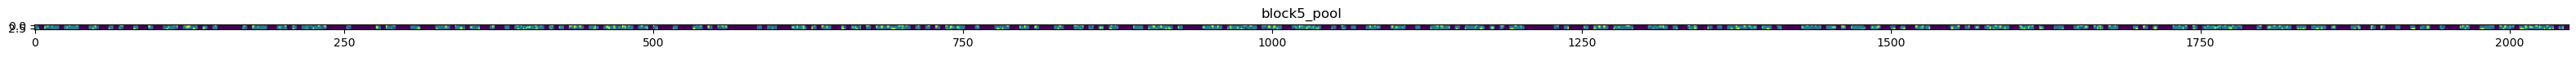

In [31]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in image_features_extract_model.layers[1:]]
visualization_model = Model(image_model.layers[0].output, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
img_path = '../../Flicker8k_Dataset/1000268201_693b08cb0e.jpg'

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in image_features_extract_model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 40. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [32]:
visualization_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [33]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [34]:
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [35]:
train_seqs[:3]

[[2, 184, 62, 331, 64, 524, 12, 329, 6, 5, 167, 3],
 [2, 11, 588, 4, 5, 2384, 895, 5, 93, 1281, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 280, 3]]

In [36]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
    return min(len(t) for t in tensor)

min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [37]:

# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [38]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

In [39]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [40]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [41]:
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x    

In [42]:
def rnn_type(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

In [43]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and 
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Rnn_Local_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
        self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Implementing Attention Mechanism 
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)
    


    def call(self, x, features, hidden):

        # features shape ==> (64,49,256) ==> Output from ENCODER

        # hidden shape == (batch_size, hidden_size) ==>(64,512)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (64, 49, 1)
        # Attention Function
        '''e(ij) = f(s(t-1),h(j))'''
        ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
        score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
        # self.Uattn(features) : (64,49,512)
        # self.Wattn(hidden_with_time_axis) : (64,1,512)
        # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
        # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
        # you get 1 at the last axis because you are applying score to self.Vattn


        # Then find Probability using Softmax
        '''attention_weights(alpha(ij)) = softmax(e(ij))'''
        attention_weights = tf.nn.softmax(score, axis=1)
        # attention_weights shape == (64, 49, 1)


        # Give weights to the different pixels in the image
        ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) ''' 
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
        # context_vector shape after sum == (64, 256)
        # x shape after passing through embedding == (64, 1, 256)
        x = self.embedding(x)
        # x shape after concatenation == (64, 1,  512)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
        # Adding Dropout and BatchNorm Layers
        x= self.dropout(x)
        x= self.batchnormalization(x)
        # output shape == (64 * 512)
        x = self.fc2(x)
        # shape : (64 * 8329(vocab))
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [44]:
encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [64]:
encoder.save("./encoder")

INFO:tensorflow:Assets written to: ./encoder/assets


INFO:tensorflow:Assets written to: ./encoder/assets


In [46]:
d = list(enumerate(dataset))
batch, (img_tensor, target) = d[10]

In [47]:
print("Batch", batch)
print("img_tensor", img_tensor)
print("target", target)

Batch 10
img_tensor tf.Tensor(
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    1.2703705 ]
  [ 0.          0.         44.946316   ...  0.          0.9400788
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          4.8112392
    0.        ]
  [ 0.          0.          0.         ...  0.          4.2288704
    0.        ]
  [ 0.          0.          0.         ...  0.          2.3556101
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.9722059
    0.        ]]

 [[ 0.          0.

In [48]:
features = encoder(img_tensor)
features[0].shape

TensorShape([49, 256])

In [49]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [50]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [51]:
EPOCHS = 50
start_epoch = 0
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7333
Epoch 1 Batch 100 Loss 1.6204
Epoch 1 Batch 200 Loss 1.3380
Epoch 1 Batch 300 Loss 1.3306
Epoch 1 Batch 400 Loss 1.3466
Epoch 1 Loss 1.442928
Time taken for 1 epoch 212.22598600387573 sec

Epoch 2 Batch 0 Loss 1.1267
Epoch 2 Batch 100 Loss 1.1909
Epoch 2 Batch 200 Loss 1.1374
Epoch 2 Batch 300 Loss 1.0673
Epoch 2 Batch 400 Loss 1.0418
Epoch 2 Loss 1.119225
Time taken for 1 epoch 199.11479210853577 sec

Epoch 3 Batch 0 Loss 1.0015
Epoch 3 Batch 100 Loss 0.9836
Epoch 3 Batch 200 Loss 1.0155
Epoch 3 Batch 300 Loss 0.9254
Epoch 3 Batch 400 Loss 0.9618
Epoch 3 Loss 1.004797
Time taken for 1 epoch 198.01742696762085 sec

Epoch 4 Batch 0 Loss 0.9962
Epoch 4 Batch 100 Loss 0.9898
Epoch 4 Batch 200 Loss 0.9077
Epoch 4 Batch 300 Loss 0.9681
Epoch 4 Batch 400 Loss 0.8718
Epoch 4 Loss 0.921691
Time taken for 1 epoch 201.90469121932983 sec

Epoch 5 Batch 0 Loss 0.9119
Epoch 5 Batch 100 Loss 0.8409
Epoch 5 Batch 200 Loss 0.8807
Epoch 5 Batch 300 Loss 0.8239
Epoch 5 Batch 

KeyboardInterrupt: 

In [52]:
len(loss_plot)

33

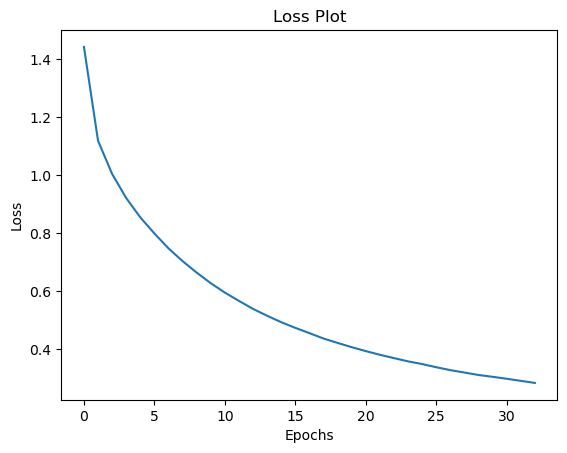

In [53]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [54]:
decoder.summary()

Model: "rnn__local__decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2132224   
                                                                 
 gru (GRU)                   multiple                  1575936   
                                                                 
 dense_1 (Dense)             multiple                  262656    
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 2048      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             multiple                  4272777   
                                               

In [55]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [56]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [60]:
decoder.save("./decoder")

INFO:tensorflow:Assets written to: ./decoder/assets


INFO:tensorflow:Assets written to: ./decoder/assets


In [61]:
image_features_extract_model.save("./image_features_extract_model")

INFO:tensorflow:Assets written to: ./image_features_extract_model/assets


INFO:tensorflow:Assets written to: ./image_features_extract_model/assets


In [57]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [58]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## captions on the validation set

BLEU-1 score: 16.666666666666668
BLEU-2 score: 6.08970970641905e-153
BLEU-3 score: 1.4961022763680928e-183
BLEU-4 score: 1.1640469867513693e-229
Real Caption: Two men are ice fishing
Predicted Caption: two men outside of pond <end>


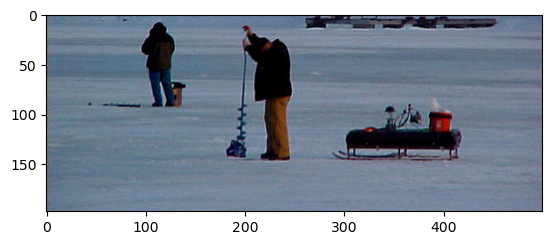

In [59]:

from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = '../../Flicker8k_Dataset/102351840_323e3de834.jpg'


# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = "Two men are ice fishing"
caption, attention_plot = evaluate(image)

# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


# # opening the image
# Image.open('/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1969573381_5ecfae4c80.jpg')

BLEU-1 score: 24.767939992862335
BLEU-2 score: 18.916826637569276
BLEU-3 score: 1.759930315134887e-91
BLEU-4 score: 6.040533861202419e-153
Real Caption: a rock climber in a red shirt .
Predicted Caption: rock climber is rock climbing wall <end>


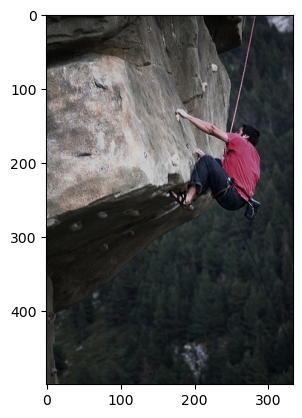

In [62]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
# image = '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1969573381_5ecfae4c80.jpg'
image = '../../Flicker8k_Dataset/997722733_0cb5439472.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = "a rock climber in a red shirt ."
caption, attention_plot = evaluate(image)

# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


# # opening the image
# Image.open('/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1969573381_5ecfae4c80.jpg')

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: a rock climber in a red shirt .
Predicted Caption: baseball player standing and faces <end>


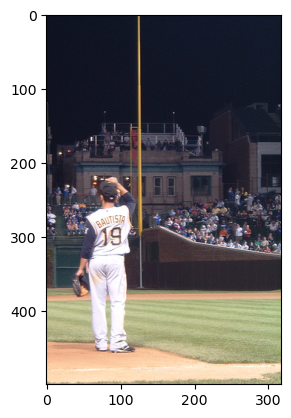

In [65]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = '../../Flicker8k_Dataset/905355838_3a43fdfd4e.jpg'


# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
# real_caption = "group of men stand outside glass and steel building"
caption, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)
print ('Predicted Caption:', ' '.join(caption))


Predicted Caption: basketball player is doing an red is getting ready to hit the phone <end>


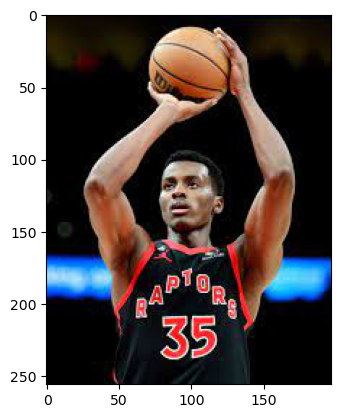

In [69]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = './download.jpeg'


# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
# real_caption = "group of men stand outside glass and steel building"
caption, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

temp_image = np.array(Image.open(image))
plt.imshow(temp_image)
print ('Predicted Caption:', ' '.join(caption))


In [66]:
from keras.applications.vgg16 import VGG16, preprocess_input
import requests

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

In [67]:
def calculateBleuScoreOfImage(url, captions):
    rid = np.random.randint(0, len(img_name_val))
    image = url
    real_captions = captions[0]
    caption, attention_plot = evaluate(image)
    #remove "<unk>" in result
    for i in caption:
        if i=="<unk>":# or  i== "<end>":
            caption.remove(i)

    for i in real_caption:
        if i=="<unk>":
            real_caption.remove(i)

    #remove <end> from result         
    result_join = ' '.join(caption)
    result_final = result_join.rsplit(' ', 1)[0]
    
    bleu = sentence_bleu(captions, result_final, weights=(0.25, 0.25, 0.25, 0.25))

    print('BLEU score -> {}'.format(bleu))

    print ('Real Captions:', captions)
    print ('Predicted Caption:', result_final)


    from PIL import Image
    import requests
    from io import BytesIO

#     response = requests.get(url, verify=False)
    temp_image = np.array(Image.open(url))
    plt.imshow(temp_image)
    return bleu

In [ ]:
# count = 1
# fig = plt.figure(figsize=(10,20))
# for jpgfnm in uni_filenames[10:15]:
#     filename = image_path + '/' + jpgfnm
#     captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    
#     count += 1
    
#     for i, caption in enumerate(captions):
#         ax.text(0,i,caption,fontsize=20)
#     count += 1
# plt.show()

In [ ]:
# # Processing COCO VAL 2014 Data for testing
# import json
# f = open('../../../COCO_VAL2014.json')
# data = json.load(f)
# f.close()

# images_caps = {}
# for ann in data['annotations']:
#     print(ann)
#     if(ann['image_id'] in images_caps):
#         images_caps[ann['image_id']].append(ann['caption'])
#     else:
#         images_caps[ann['image_id']] = [ann['caption']]
        
        
# val_data = []
# for im in data['images']:
#     val_data.append({'url':im['url'], 'captions': images_caps[im['id']] })

In [ ]:
test_data = data.sample(n = 1000)
test_data = test_data.reset_index()

In [ ]:
test_data

In [ ]:
img = 151
bleu_scores.append(calculateBleuScoreOfImage('../../Flicker8k_Dataset/'+test_data['filename'][img],test_data['caption'][img]))

In [ ]:
bleu_scores

In [ ]:
np.mean(bleu_scores)*100